In [131]:
# !pip install openfermion
import itertools

import lovelyplots
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from openfermion import normal_ordered
from openfermion.ops import BosonOperator
from sympy import I, Symbol, solve
from tqdm.notebook import tqdm

In [ ]:
# Define symbols for parameters
ws = Symbol("w_s", real=True, positive=True)  # Frequency for s operator
wp = Symbol("w_p", real=True, positive=True)  # Pump frequency
eta = Symbol("\\eta", real=True)  # Scalar for eta, assume real for simplifications
eta_star = eta.conjugate()  # Complex conjugate of eta
lambda_si = Symbol("\\lambda", real=True, positive=True)
g3 = Symbol("g_3", real=True, positive=True)
alpha_i = Symbol("\\alpha_i", real=True, positive=True)
N = 2  # Number of qubit modes
t = Symbol("t", real=True, positive=True)

# Define the cubic term components as (BosonOperator, frequency term)
cubic_terms = (
    [
        (BosonOperator("0", 1), -ws),  # s operator with -ws frequency
        (BosonOperator("0^", 1), ws),  # s^ operator with ws frequency
        (BosonOperator("", eta), -wp),  # eta with -wp frequency
        (BosonOperator("", eta_star), wp),  # eta* with wp frequency
    ]
    + [(BosonOperator(f"{i}", lambda_si), -Symbol(f"w_q{i}")) for i in range(1, N + 1)]
    + [(BosonOperator(f"{i}^", lambda_si), Symbol(f"w_q{i}")) for i in range(1, N + 1)]
)

# Define the quartic term components for each qubit mode `q_i`
quartic_terms = []
for i in range(1, N + 1):
    # Define the terms for (q_i^ + q_i - lambda_si * (s, s^, eta, eta^ )) for each i
    quartic_base_terms = [
        (BosonOperator(f"{i}", 1), -Symbol(f"w_q{i}")),  # q_i with -w_qi frequency
        (BosonOperator(f"{i}^", 1), Symbol(f"w_q{i}")),  # q_i^ with w_qi frequency
        (BosonOperator("0", -lambda_si), -ws),
        (BosonOperator("0^", -lambda_si), ws),
        (BosonOperator("", -lambda_si * eta), -wp),
        (BosonOperator("", -lambda_si * eta_star), wp),
    ]
    quartic_terms.append(quartic_base_terms)


# Function to generate polynomial expansions for a list of terms with a specific order
def generate_polynomial_terms(terms, order):
    polynomial_terms = list(itertools.product(terms, repeat=order))
    expanded_terms = []

    for combo in polynomial_terms:
        # Separate the BosonOperator and frequency terms
        operator_product = BosonOperator("", 1)  # Start with the identity operator
        frequency_sum = 0  # Initialize frequency sum

        for op, freq in combo:
            operator_product *= op
            frequency_sum += freq

        expanded_terms.append((operator_product, frequency_sum))

    return expanded_terms


# Expand the cubic term (g3 * (cubic_terms)^3)
expanded_cubic_terms = [
    (g3 * term[0], term[1]) for term in generate_polynomial_terms(cubic_terms, 3)
]

# Expand the quartic term for each `q_i` (alpha_i/12 * (quartic_base_terms)^4)
expanded_quartic_terms = []
for quartic_base_terms in quartic_terms:
    expanded_terms = generate_polynomial_terms(quartic_base_terms, 4)
    expanded_quartic_terms.extend(
        [(alpha_i / 12 * term[0], term[1]) for term in expanded_terms]
    )

In [133]:
# Display a few terms to verify structure
print("Cubic Terms (Expanded):")
for term in expanded_cubic_terms[:3]:  # Show first few terms as example
    print(term)

print("\nQuartic Terms (Expanded):")
for term in expanded_quartic_terms[:3]:  # Show first few terms as example
    print(term)

Cubic Terms (Expanded):
(g_3 [0 0 0], -3*w_s)
(g_3 [0 0 0^], -w_s)
(\eta*g_3 [0 0], -w_p - 2*w_s)

Quartic Terms (Expanded):
(\alpha_i/12 [1 1 1 1], -4*w_q1)
(\alpha_i/12 [1 1 1 1^], -2*w_q1)
(-\alpha_i*\lambda/12 [0 1 1 1], -3*w_q1 - w_s)


In [134]:
# for all terms, group by exp term
expanded_terms = expanded_cubic_terms + expanded_quartic_terms
expanded_terms_grouped = {}
for term in expanded_terms:
    if term[1] not in expanded_terms_grouped:
        expanded_terms_grouped[term[1]] = []
    expanded_terms_grouped[term[1]].append(term[0])

# we wait to combine them together because calls to sum and normal_ordered are expensive
# when it uses custom implementation specific to BosonOperator
simplified_terms_dict = {}
for k, v in tqdm(list(expanded_terms_grouped.items())[:]):
    # simplified_terms_dict[k] = normal_ordered(v[0].accumulate(v[1:]))
    simplified_terms_dict[k] = normal_ordered(sum(v))  # NOTE: slower?

  0%|          | 0/241 [00:00<?, ?it/s]

In [135]:
# look at some example terms
# list(simplified_terms_dict.items())[40:50]
simplified_terms_dict

{-3*w_s: g_3 [0 0 0],
 -w_s: 6*\eta**2*g_3 + 6*\lambda**2*g_3 + 3*g_3 [0] +
 6*\lambda**2*g_3 [0 1^ 1] +
 6*\lambda**2*g_3 [0 2^ 2] +
 3*g_3 [0^ 0 0],
 -w_p - 2*w_s: 3*\eta*g_3 [0 0],
 w_p - 2*w_s: 3*\eta*g_3 [0 0],
 -w_q1 - 2*w_s: 3*\lambda*g_3 [0 0 1],
 -w_q2 - 2*w_s: 3*\lambda*g_3 [0 0 2],
 w_q1 - 2*w_s: 3*\lambda*g_3 [0 0 1^],
 w_q2 - 2*w_s: 3*\lambda*g_3 [0 0 2^],
 w_s: 6*\eta**2*g_3 + 6*\lambda**2*g_3 + 3*g_3 [0^] +
 3*g_3 [0^ 0^ 0] +
 6*\lambda**2*g_3 [0^ 1^ 1] +
 6*\lambda**2*g_3 [0^ 2^ 2],
 -w_p: 3*\eta**3*g_3 + 6*\eta*\lambda**2*g_3 + 3*\eta*g_3 [] +
 6*\eta*g_3 [0^ 0] +
 6*\eta*\lambda**2*g_3 [1^ 1] +
 6*\eta*\lambda**2*g_3 [2^ 2],
 w_p: 3*\eta**3*g_3 + 6*\eta*\lambda**2*g_3 + 3*\eta*g_3 [] +
 6*\eta*g_3 [0^ 0] +
 6*\eta*\lambda**2*g_3 [1^ 1] +
 6*\eta*\lambda**2*g_3 [2^ 2],
 -w_q1: 6*\lambda*g_3 [0^ 0 1] +
 6*\eta**2*\lambda*g_3 + 6*\lambda**3*g_3 + 3*\lambda*g_3 [1] +
 6*\lambda**3*g_3 [1 2^ 2] +
 3*\lambda**3*g_3 [1^ 1 1],
 -w_q2: 6*\lambda*g_3 [0^ 0 2] +
 6*\lambda**3*g_


### SNAIL Subharmonics
For SNAIL subharmonics, we have:

<!-- 
\[
-2 w_p + w_s : 3 \eta^2 g_3 [0^\dagger]
\]

\[
2 w_p - w_s : 3 g_3 \bar{\eta}^2 [0]
\]

\[
-3 w_p + w_s : \alpha_i \eta^3 \lambda^4 [0^\dagger]
\]

\[
3 w_p - w_s : \alpha_i \lambda^4 \bar{\eta}^3 [0]
\]
-->

- When  $ w_p := \frac{w_s}{2}  $, it activates  $ 3 g_3 \left(\eta^2 s^\dagger + \bar{\eta}^2 s\right)  $,
- When  $ w_p := \frac{w_s}{3}  $, it activates  $ (N/3) * \alpha_i \lambda^4 \left(\eta^3 s^\dagger + \bar{\eta}^3 s\right)  $.

Here,  $ s  $ represents the SNAIL operator, $N$ is number of qubits.

### Qubit Subharmonics
For qubit subharmonics, we have:

<!-- 
\[
2 w_p - w_{q1} : 3 g_3 \lambda_{si} \bar{\eta}^2 [1]
\]

\[
-2 w_p + w_{q1} : 3 \eta^2 g_3 \lambda_{si} [1^\dagger]
\]

\[
3 w_p - w_{q1} : -\frac{1}{3} \alpha_i \lambda_{si}^3 \bar{\eta}^3 [1]
\]

\[
-3 w_p + w_{q1} : -\frac{1}{3} \alpha_i \eta^3 \lambda_{si}^3 [1^\dagger]
\]
-->

- When  $ w_p := \frac{w_q}{2}  $, it activates  $ 3 g_3 \lambda_{si} \left(\bar{\eta}^2 q + \eta^2 q^\dagger \right)  $,
- When  $ w_p := \frac{w_q}{3}  $, it activates  $ -\frac{1}{3} \alpha_i \lambda_{si}^3 \left(\bar{\eta}^3 q + \eta^3 q^\dagger \right)  $.

In [162]:
# we want to split the terms into two groups
# (a) dependent on w_p vs (b) independent of w_p
# (a) are activated by the pump whereas (b) are thus always present
# additionally, for a term in (a), we solve for pump frequency such that the term is zero
# and then make that value the new dictionary key

qubit_frequency_values = [4, 17 / 3, 6]
snail_frequency = 13 / 3
symbol_subs = {
    Symbol(f"w_q{i}"): freq for i, freq in enumerate(qubit_frequency_values, 1)
}
symbol_subs.update({ws: snail_frequency})
sub_terms_dict = {}
for k, v in simplified_terms_dict.items():
    new_k = k.subs(symbol_subs)
    if new_k not in sub_terms_dict:
        sub_terms_dict[new_k] = 0
    sub_terms_dict[new_k] += v

sub_terms_dict_wp = {}
sub_terms_dict_reverse = {}
sub_terms_dict_always = {}
for k, v in tqdm(sub_terms_dict.items()):
    if wp in k.free_symbols:
        wp_val = solve(k, wp)
        if not wp_val:
            continue
        if not wp_val[0] in sub_terms_dict_wp:
            sub_terms_dict_wp[wp_val[0]] = 0
        sub_terms_dict_wp[wp_val[0]] += v
        sub_terms_dict_reverse[str(v)] = wp_val[0]

    else:
        sub_terms_dict_always[k] = v

  0%|          | 0/239 [00:00<?, ?it/s]

In [163]:
# # prune any where the 0<=key<=0.5
# print(len(sub_terms_dict_always))
# # interesting to look at if there are any terms present that could be persistent error term
# ie plt.xlabel(r"$\theta$ (Frequency, $H = \text{operator} \cdot e^{-i t \theta}$)")
# sub_terms_dict_always = {k: v for k, v in sub_terms_dict_always.items() if 0 <= k < 0.5}
# print(len(sub_terms_dict_always))

print(len(sub_terms_dict_wp))
# prune such that keep only if between 0 and 2
filtered_sub_terms_dict_wp = {
    k: v for k, v in sub_terms_dict_wp.items() if 0 <= k <= 2.2
}
print(len(filtered_sub_terms_dict_wp))
# sub_terms_dict_wp
sub_terms_dict_reverse

33
10


{'3*\\eta*g_3 [0 0]': 8.66666666666667,
 '6*\\eta*\\lambda*g_3 [0 2^]': 1.33333333333333,
 '3*\\eta**2*g_3 [0]': 2.16666666666667,
 '6*\\eta*\\lambda*g_3 [0 1]': 8.33333333333333,
 '6*\\eta*\\lambda*g_3 [0 2]': 10.0000000000000,
 '6*\\eta*\\lambda*g_3 [0 1^]': 0.333333333333333,
 '3*\\eta*g_3 [0^ 0^]': 8.66666666666667,
 '3*\\eta**2*g_3 [0^]': 2.16666666666667,
 '6*\\eta*\\lambda*g_3 [0^ 1]': 0.333333333333333,
 '6*\\eta*\\lambda*g_3 [0^ 1^]': 8.33333333333333,
 '6*\\eta*\\lambda*g_3 [0^ 2^]': 10.0000000000000,
 '6*\\eta*\\lambda*g_3 [0^ 2]': 1.33333333333333,
 '3*\\eta**2*\\lambda*g_3 [1^]': 2,
 '3*\\eta**2*\\lambda*g_3 [2^]': 2.83333333333333,
 '6*\\eta*\\lambda**2*g_3 [1 2^]': 1.66666666666667,
 '3*\\eta*\\lambda**2*g_3 [1^ 1^]': 8,
 '6*\\eta*\\lambda**2*g_3 [1^ 2^]': 9.66666666666667,
 '3*\\eta*\\lambda**2*g_3 [2^ 2^]': 11.3333333333333,
 '3*\\eta**2*\\lambda*g_3 [1]': 2,
 '3*\\eta**2*\\lambda*g_3 [2]': 2.83333333333333,
 '3*\\eta*\\lambda**2*g_3 [1 1]': 8,
 '6*\\eta*\\lambda**2*g_

In [164]:
op = list(filtered_sub_terms_dict_wp.items())[-2][1]
simplfied_op_string = []


def _format_operator_tuple(op_tuple):
    # op_tuple is a tuple (int, int)
    # first element
    # Replace "0" with "s" and "i" with "q_i" format for qubits
    # second element, if 1 gets a ^\dagger
    op_str = ""
    if op_tuple[0] == 0:
        op_str += "s"
    else:
        op_str += f"q_{op_tuple[0]}"
    if op_tuple[1] == 1:
        op_str += "^{\\dagger}"
    return op_str


from sympy import factor, latex


def _format_operator(op):
    ops = 0
    for termk, termv in op.terms.items():
        ops += termv * Symbol(
            " ".join(_format_operator_tuple(op_tuple) for op_tuple in termk)
        )
    return f"${latex(factor(ops), fold_short_frac =True)}$"


formated_sub_terms_dict_wp = {
    k: _format_operator(v) for k, v in filtered_sub_terms_dict_wp.items()
}
formated_sub_terms_dict_wp

{1.33333333333333: '$6 \\eta \\lambda g_{3} \\left(s q_2^{\\dagger} + s^{\\dagger} q_2\\right)$',
 2.16666666666667: '$3 \\eta^{2} g_{3} \\left(s + s^{\\dagger}\\right)$',
 0.333333333333333: '$6 \\eta \\lambda g_{3} \\left(s q_1^{\\dagger} + s^{\\dagger} q_1\\right)$',
 2: '$3 \\eta^{2} \\lambda g_{3} \\left(q_{1} + q_1^{\\dagger}\\right)$',
 1.66666666666667: '$6 \\eta \\lambda^{2} g_{3} \\left(q_1 q_2^{\\dagger} + q_1^{\\dagger} q_2\\right)$',
 0.166666666666667: '$- \\alpha_{i} \\eta^{2} \\lambda^{3} \\left(s q_1^{\\dagger} + s^{\\dagger} q_1\\right)$',
 4/3: '$- \\alpha_{i} \\eta^{3} \\lambda^{3} \\left(q_{1} + q_1^{\\dagger}\\right) / 3$',
 1.44444444444444: '$2 \\alpha_{i} \\eta^{3} \\lambda^{4} \\left(s + s^{\\dagger}\\right) / 3$',
 0.666666666666667: '$- \\alpha_{i} \\eta^{2} \\lambda^{3} \\left(s q_2^{\\dagger} + s^{\\dagger} q_2\\right)$',
 1.88888888888889: '$- \\alpha_{i} \\eta^{3} \\lambda^{3} \\left(q_{2} + q_2^{\\dagger}\\right) / 3$'}

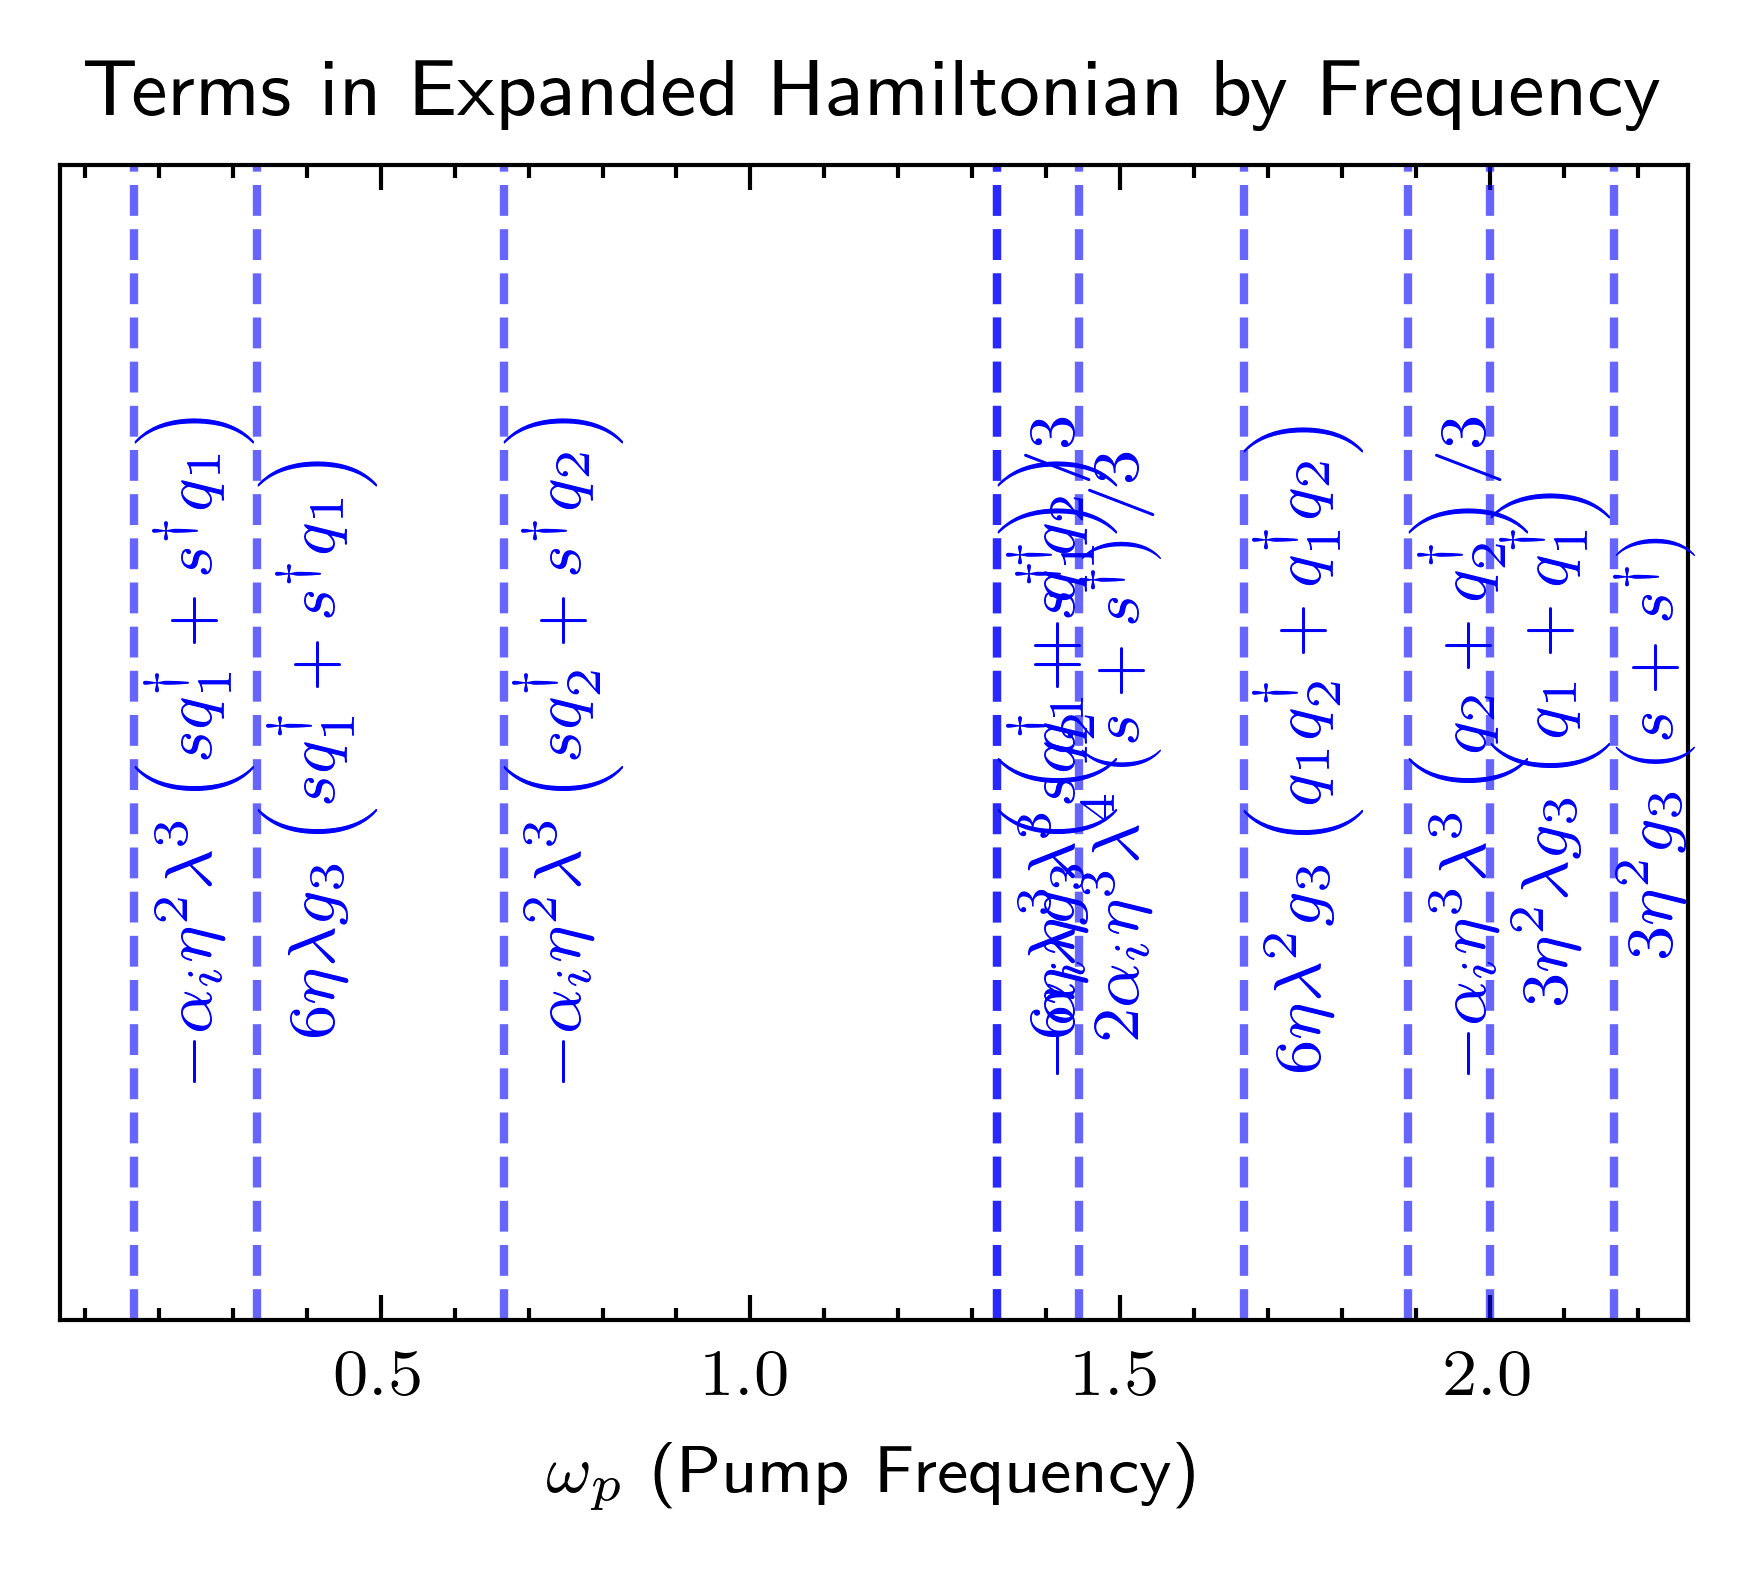

In [165]:
# Plot the results using consistent style
# need a helper to replace BosonOperator with strings
# {0: "s", i: "q_i"},; remove [], replace ^ with ^\dagger
# def _format_operator_string(operator_string):
#     operator_string = str(operator_string).replace("\n", "")

#     # Replace "0" with "s" and "i" with "q_i" format for qubits
#     operator_string = re.sub(r"\b0\b", "s", operator_string)
#     operator_string = re.sub(r"\b(\d+)\b", r"q_\1", operator_string)
#     # Replace "^" with "^\dagger"
#     operator_string = operator_string.replace("^", "^\dagger")
#     # Replace "[" and "]" with "(" and ")"
#     operator_string = operator_string.replace("[", "(").replace("]", ")")
#     # Replace "*" with a space
#     operator_string = operator_string.replace("*", " ")
#     # Convert conjugate(anything) to anything^*
#     operator_string = re.sub(r"conjugate\((.+?)\)", r"\1^*", operator_string)
#     return "$" + operator_string + "$"


with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, ax1 = plt.subplots(figsize=(3.5, 2.5))  # Adjust figure size

    # Plot each frequency term as a vertical line with label
    for frequency, operator_string in formated_sub_terms_dict_wp.items():
        ax1.axvline(x=frequency, color="blue", linestyle="--", alpha=0.6)
        ax1.text(
            frequency,
            0.5,
            operator_string,
            rotation=90,
            verticalalignment="center",
            color="blue",
            fontsize=8,
        )

    # Formatting the plot
    ax1.set_xlabel(r"$\omega_p$ (Pump Frequency)")
    ax1.set_title("Terms in Expanded Hamiltonian by Frequency")
    ax1.set_yticks([])  # Remove y-axis ticks for a cleaner 1D appearance
plt.show()